Captum (“comprehension” in Latin) is an open source, extensible library for model interpretability built on PyTorch.

Captum’s approach to model interpretability is in terms of attributions. There are three kinds of attributions available in Captum:

 - Feature Attribution seeks to explain a particular output in terms of features of the input that generated it. Explaining whether a movie review was positive or negative in terms of certain words in the review is an example of feature attribution.
 - Layer Attribution examines the activity of a model’s hidden layer subsequent to a particular input. Examining the spatially-mapped output of a convolutional layer in response to an input image in an example of layer attribution.
 - Neuron Attribution is analagous to layer attribution, but focuses on the activity of a single neuron.

In [29]:
!pip install captum Flask-Compress

     |████████████████████████████████| 357 kB 5.3 MB/s 


In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models

import captum
from captum.attr import (
    IntegratedGradients,
    Occlusion,
    LayerGradCam,
    LayerAttribution,
    visualization as viz
)

import os
import sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [7]:
model = models.alexnet(pretrained=True)
model = model.eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

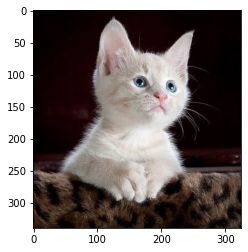

In [11]:
test_img = Image.open('cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show();

In [5]:
!wget https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json

--2022-02-04 14:19:56--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.003s  

2022-02-04 14:19:57 (10.8 MB/s) - ‘imagenet_class_index.json.1’ saved [35363/35363]



In [12]:
transform = T.Compose([
                       T.Resize(224),
                       T.CenterCrop(224),
                       T.ToTensor()
])
# standard ImageNet normalization
transform_normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # Adding batch dimension

labels_path = 'imagenet_class_index.json'
with open(labels_path) as json_data:
  idx_to_labels = json.load(json_data)

In [13]:
output = model(input_img)
output = F.softmax(output, dim=1)
pred_score, pred_idx = torch.topk(output, 1)
pred_idx.squeeze_()
pred_label = idx_to_labels[str(pred_idx.item())][1]
print(f'Predicted: {pred_label}, ({pred_score.squeeze().item()})')

Predicted: Egyptian_cat, (0.6384816765785217)


# Feature Attribution with Integrated Gradients

Integrated Gradients is one of the feature attribution algorithms available in Captum. Integrated Gradients assigns an importance score to each input feature by approximating the integral of the gradients of the model’s output with respect to the inputs.

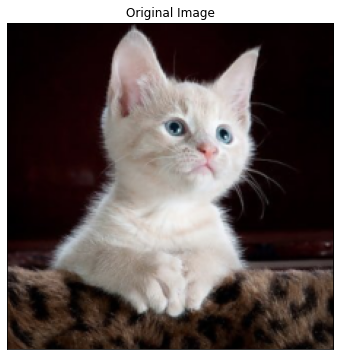

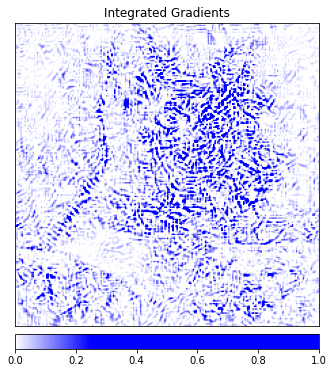

In [14]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None,
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                             method='original_image', title='Original Image')

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [
                                                  (0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')
                                                 ], N=256)

_ = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    title='Integrated Gradients'
)

# Feature Attribution with Occlusion

Perturbation-based attribution methods approach this more directly, by introducing changes to the output to measure the effect on the output. Occlusion is one such method. It involves replacing sections of the input image, and examining the effect on the output signal.

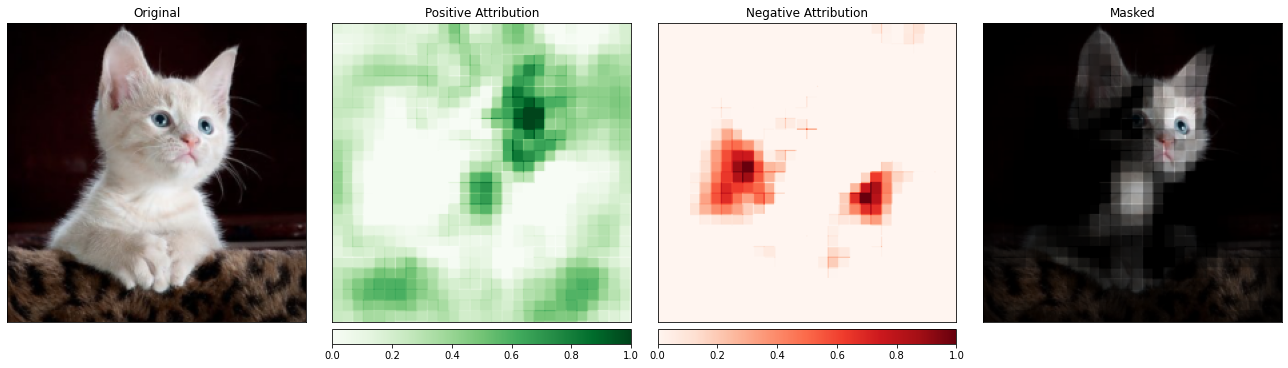

In [15]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ['original_image', 'heat_map', 'heat_map', 'masked_image'],
    ['all', 'positive', 'negative', 'positive'],
    show_colorbar=True,
    titles=['Original', 'Positive Attribution', 'Negative Attribution', 'Masked'],
    fig_size=(18, 6)
)

# Layer Attribution with Layer GradCAM
Layer Attribution allows you to attribute the activity of hidden layers within your model to features of your input.
GradCAM computes the gradients of the target output with respect to the given layer, averages for each output channel (dimension 2 of output), and multiplies the average gradient for each channel by the layer activations. The results are summed over all channels. GradCAM is designed for convnets; since the activity of convolutional layers often maps spatially to the input, GradCAM attributions are often upsampled and used to mask the input.

In [16]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
model.features[3], model.features[10]

(Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

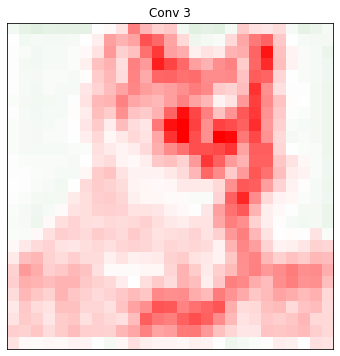

In [21]:
layer_gradcam = LayerGradCam(model, model.features[3])
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_idx)

_ = viz.visualize_image_attr(
    attributions_lgc[0].cpu().permute(1, 2, 0).detach().numpy(),
    sign='all',
    title='Conv 3'
)

torch.Size([1, 1, 27, 27])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


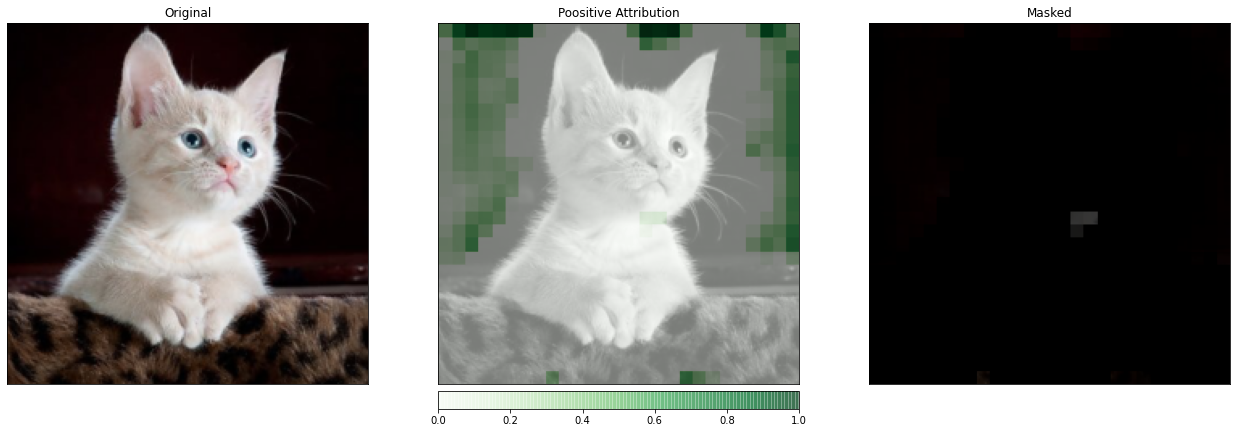

In [23]:
# upsampling the attribution data
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(
    upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
    transformed_img.permute(1, 2, 0).numpy(),
    ['original_image', 'blended_heat_map', 'masked_image'],
    ['all', 'positive', 'positive'],
    show_colorbar=True,
    titles=['Original', 'Poositive Attribution', 'Masked'],
    fig_size=(18, 6)
)

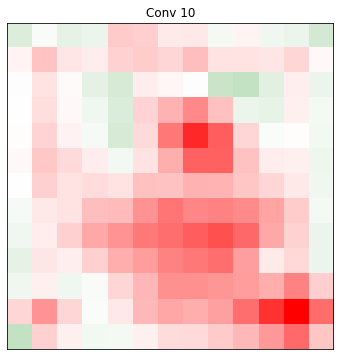

In [24]:
layer_gradcam = LayerGradCam(model, model.features[10])
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_idx)

_ = viz.visualize_image_attr(
    attributions_lgc[0].cpu().permute(1, 2, 0).detach().numpy(),
    sign='all',
    title='Conv 10'
)

torch.Size([1, 1, 13, 13])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


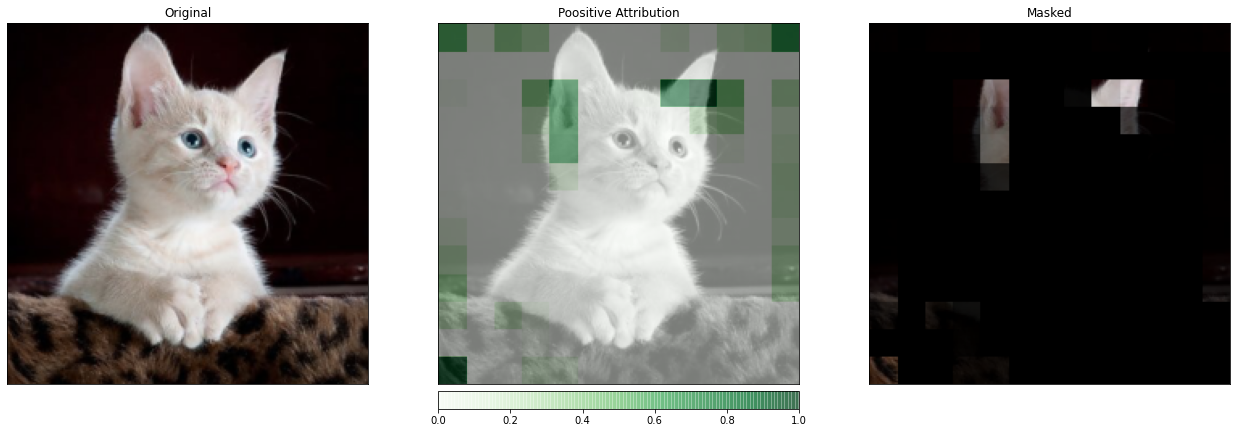

In [25]:
# upsampling the attribution data
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(
    upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
    transformed_img.permute(1, 2, 0).numpy(),
    ['original_image', 'blended_heat_map', 'masked_image'],
    ['all', 'positive', 'positive'],
    show_colorbar=True,
    titles=['Original', 'Poositive Attribution', 'Masked'],
    fig_size=(18, 6)
)

# Visualization with Captum Insights

In [27]:
imgs = ['cat.jpg', 'teapot.jpg', 'trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: Egyptian_cat / 285  ( 0.6384816765785217 )
Predicted: teapot / 849  ( 0.8145760893821716 )
Predicted: trilobite / 69  ( 0.9996483325958252 )


In [38]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i

input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)

In [35]:
from google.colab import output
output.enable_custom_widget_manager()

In [39]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()